In [10]:
import numpy as np
%load_ext line_profiler
%load_ext autoreload
%autoreload 2
from pycuda.tools import DeviceData as DD
import matplotlib
%matplotlib inline

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
dd = DD()
dd.max_threads

1024

In [3]:
import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
from pycuda.elementwise import ElementwiseKernel
manual_gpu = ElementwiseKernel(
    "pycuda::complex<float> *q, int *output, int maxiter",
    """
    {
        float nreal, real = 0;
        float imag = 0;
        output[i] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            float real2 = real*real;
            float imag2 = imag*imag;
            nreal = real2 - imag2 + q[i].real();
            imag = 2* real*imag + q[i].imag();
            real = nreal;
            if (real2 + imag2 > 4.0f){
                output[i] = curiter;
                break;
                };
        };
    }
    """,
    "complex5",
    preamble="#include <pycuda-complex.hpp>",)
complex_gpu = ElementwiseKernel(
    "pycuda::complex<float> *q, int *output, int maxiter",
    """
    {
        pycuda::complex<float> z = q[i];
        output[i] = 0;
        for(int curiter = 0; curiter < maxiter; curiter++) {
            pycuda::complex<float> z2 = z*z ;
            z = z2+q[i];
            if (z.real()*z.real()+z.imag()*z.imag() > 4.0f){
                output[i] = curiter;
                break;
                };
        };
    }
    """,
    "complex5",
    preamble="#include <pycuda-complex.hpp>",)
def mandelbrot_gpu(c, maxiter):
    q_gpu = gpuarray.to_gpu(c.astype(np.complex64))
    iterations_gpu = gpuarray.to_gpu(np.empty(c.shape, dtype=np.int))
    manual_gpu(q_gpu, iterations_gpu, maxiter)

    return iterations_gpu.get()
def mandelbrot_set(xmin,xmax,ymin,ymax,width,height,maxiter):
    r1 = np.linspace(xmin, xmax, width, dtype=np.float32)
    r2 = np.linspace(ymin, ymax, height, dtype=np.float32)
    c = r1 + r2[:,None]*1j
#     n3 = np.empty(c.shape, int)
#     maxit = np.ones(c.shape, int) * maxiter
    n3 = mandelbrot_gpu(c,maxiter)
    return (r1,r2,n3.T) 
%timeit mandelbrot_set(-0.74877,-0.74872,0.06505,0.06510,1000,1000,2048)

The slowest run took 5.06 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 47.2 ms per loop


In [36]:
# attempt to do matrix multiplication for real numbers
import pycuda.autoinit
from numpy import linalg as la
from pycuda import driver, compiler, gpuarray, tools
import numpy as np
from time import *

kernel_code_template = """

    __global__ void MatrixMulKernel(float *A, float *B, float *C)
    {

      const uint wA = %(MATRIX_dimt)s;
      const uint wB = %(MATRIX_dimx)s;  

      // Block index
      const uint bx = blockIdx.x;
      const uint by = blockIdx.y;
      
      // Thread index
      const uint tx = threadIdx.x;
      const uint ty = threadIdx.y;

      // Index of the first sub-matrix of A processed by the block
      const uint aBegin = wA * %(BLOCK_SIZE)s * by;
      // Index of the last sub-matrix of A processed by the block
      const uint aEnd = aBegin + wA - 1;
      // Step size used to iterate through the sub-matrices of A
      const uint aStep = %(BLOCK_SIZE)s;

      // Index of the first sub-matrix of B processed by the block
      const uint bBegin = %(BLOCK_SIZE)s * bx;
      // Step size used to iterate through the sub-matrices of B
      const uint bStep = %(BLOCK_SIZE)s * wB;

      // The element of the block sub-matrix that is computed
      // by the thread
      float Csub = 0;
      // Loop over all the sub-matrices of A and B required to
      // compute the block sub-matrix
      for (int a = aBegin, b = bBegin;
           a <= aEnd;
           a += aStep, b += bStep) 
        {
          // Shared memory for the sub-matrix of A
          __shared__ float As[%(BLOCK_SIZE)s][%(BLOCK_SIZE)s];
          // Shared memory for the sub-matrix of B
          __shared__ float Bs[%(BLOCK_SIZE)s][%(BLOCK_SIZE)s];

          // Load the matrices from global memory to shared memory
          // each thread loads one element of each matrix
          As[ty][tx] = A[a + wA * ty + tx];
          Bs[ty][tx] = B[b + wB * ty + tx];
          // Synchronize to make sure the matrices are loaded
          __syncthreads();

          // Multiply the two matrices together;
          // each thread computes one element
          // of the block sub-matrix
          for (int k = 0; k < %(BLOCK_SIZE)s; ++k)
            Csub += As[ty][k] * Bs[k][tx];

          // Synchronize to make sure that the preceding
          // computation is done before loading two new
          // sub-matrices of A and B in the next iteration
          __syncthreads();
        }

      // Write the block sub-matrix to global memory;
      // each thread writes one element
      const uint c = wB * %(BLOCK_SIZE)s * by + %(BLOCK_SIZE)s * bx;
      C[c + wB * ty + tx] = Csub;
    }
    """

# define the (square) matrix size
MATRIX_dimx = 6; MATRIX_dimy = 4; MATRIX_dimt = 2

# define size of blocks and tiles sub-matrix 
# (we assume that the block size is same as tile size)
TILE_SIZE = 2
BLOCK_SIZE = TILE_SIZE

# create two random square matrices
a_cpu = np.random.randn(MATRIX_dimy,MATRIX_dimt).astype(np.float32)
b_cpu = np.random.randn(MATRIX_dimt,MATRIX_dimx).astype(np.float32)

# compute reference on the CPU to verify GPU computation
c_cpu = np.dot(a_cpu, b_cpu)

# transfer host (CPU) memory to device (GPU) memory 
a_gpu = gpuarray.to_gpu(a_cpu) 
b_gpu = gpuarray.to_gpu(b_cpu)

# create empty gpu array for the result (C = A * B)
c_gpu = gpuarray.empty((MATRIX_dimy,MATRIX_dimx), np.float32)

# get the kernel code from the template 
# by specifying the constants MATRIX_SIZE and BLOCK_SIZE
kernel_code = kernel_code_template % { 
    'MATRIX_dimx': MATRIX_dimx,
    'MATRIX_dimy': MATRIX_dimy,
    'MATRIX_dimt': MATRIX_dimt,
    'BLOCK_SIZE': BLOCK_SIZE,
    }

# compile the kernel code
mod = compiler.SourceModule(kernel_code)

# get the kernel function from the compiled module
matrixmul = mod.get_function("MatrixMulKernel")

# call the kernel on the card
matrixmul(
    # inputs
    a_gpu, b_gpu, 
    # output
    c_gpu, 
    # grid of multiple blocks
    grid = (MATRIX_dimy // TILE_SIZE, MATRIX_dimx // TILE_SIZE),
    # block of multiple threads
    block = (TILE_SIZE, TILE_SIZE, 1), 
    )

# print the results
print "-" * 80
print "Matrix C (GPU):"
print c_gpu.get()

print "-" * 80
print "Matrix C (CPU):"
print c_cpu

print "-" * 80
print "Matrix C (GPU-CPU):"
print c_gpu.get()-c_cpu

print "-" * 80
print "CPU-GPU difference:"
print c_cpu - c_gpu.get()
print "L2 norm:", la.norm(c_cpu - c_gpu.get())
np.allclose(c_cpu, c_gpu.get())


--------------------------------------------------------------------------------
Matrix C (GPU):
[[ -1.74063993e+00  -4.83457774e-01   7.48204410e-01   4.91789818e-01
    1.67654026e+00   4.63115215e-01]
 [  4.84271288e+00   1.87281930e+00  -1.28794456e+00  -1.13162361e-01
   -2.34757137e+00   6.80427432e-01]
 [  1.39599895e+00   1.70880884e-01  -9.26170766e-01  -9.10108626e-01
    6.37761176e-01  -5.33797264e-01]
 [ -8.80502701e-01  -4.10058141e-01   1.29596099e-01  -1.44799531e-01
    2.27723206e-38   2.27723206e-38]]
--------------------------------------------------------------------------------
Matrix C (CPU):
[[-1.74063993 -0.48345777  0.74820441  0.49178982 -2.95092463 -1.00793302]
 [ 4.84271288  1.8728193  -1.28794456 -0.11316236  2.25557208  1.5172292 ]
 [ 1.39599895  0.17088088 -0.92617077 -0.91010863  4.81320906  1.33717203]
 [-0.8805027  -0.41005814  0.1295961  -0.14479953  0.37446681 -0.10628237]]
----------------------------------------------------------------------------

False

In [31]:
# attempt to do matrix multiplication for complex numbers
import pycuda.autoinit
from pycuda import driver, compiler, gpuarray, tools    
import numpy as np
from time import *

kernel_code_template = """
            #include <cuComplex.h>
    __global__ void MatrixMulKernel(cuFloatComplex *A, cuFloatComplex *B, cuFloatComplex *C)
    {
          const uint wA = %(MATRIX_dimt)s;
          //const uint hA = %(MATRIX_dimy)s;
          const uint wB = %(MATRIX_dimx)s;
          //const uint hB = %(MATRIX_dimt)s;

          // Block index
          const uint bx = blockIdx.x;
          const uint by = blockIdx.y;

          // Thread index
          const uint tx = threadIdx.x;
          const uint ty = threadIdx.y;

          // Index of the first sub-matrix of A processed by the block
          const uint aBegin = wA * %(BLOCK_dimy)s * by;
          // Index of the last sub-matrix of A processed by the block
          const uint aEnd   = aBegin + wA - 1;
          // Step size used to iterate through the sub-matrices of A
          const uint aStep = %(BLOCK_dimt)s;

          // Index of the first sub-matrix of B processed by the block
          const int bBegin = %(BLOCK_dimx)s * bx;
          // Step size used to iterate through the sub-matrcies of B
          const uint bStep = %(BLOCK_dimt)s * wB;

          // The element of the block sub-matrix that is computed by the thread
          cuFloatComplex Csub = make_cuFloatComplex(0,0);
          
          // Loop over all the sub-matrices of A and B required to compute the block sub-matrix
          for (int a = aBegin, b = bBegin;
               a <= aEnd;
           a += aStep, b += bStep)
          {
               // Shared memory for the sub-matrix of A
           __shared__ cuFloatComplex As[%(BLOCK_dimy)s][%(BLOCK_dimt)s];
           // Shared memory for the sub-matrix of B
           __shared__ cuFloatComplex Bs[%(BLOCK_dimt)s][%(BLOCK_dimx)s];

           // Load the matrices from global memory to shared memory;
           // each thread loads one element of each matrix, access error if BLOCK not square
           As[ty][tx] = make_cuFloatComplex(cuCrealf(A[a + wA*ty + tx]),cuCimagf(A[a + wA*ty + tx]));
           Bs[ty][tx] = make_cuFloatComplex(cuCrealf(B[b + wB*ty + tx]),cuCimagf(B[b + wA*ty + tx]));

           // Synchronize to make sure the matrices are loaded
           __syncthreads();

           // Multiply the two matrcies together
           // each thread computes one element of the block sub-matrix
           for(int k = 0; k < %(BLOCK_dimt)s; ++k)
           {
                Csub = cuCaddf(Csub,cuCmulf(As[ty][k],Bs[k][tx]));
           } 

           // Synchronize to make sure that the preceding computation
           // is done before loading two new sub-matrices of A and B in the next iteration
           __syncthreads();
         }

         // Write the block sub-matrix to global memory
         // each thread writes one element
         const uint c = wB * %(BLOCK_dimy)s * by + %(BLOCK_dimx)s * bx;
         C[c + wB*ty + tx] = make_cuFloatComplex(cuCrealf(Csub), cuCimagf(Csub));
    }
    """

MATRIX_dimx = 400; MATRIX_dimy = 400; MATRIX_dimt = 400
TILE_dimx  = 20; TILE_dimy = 20
BLOCK_dimx = TILE_dimx; BLOCK_dimy = TILE_dimy

a_cpu = np.random.rand(MATRIX_dimy,MATRIX_dimt).astype(np.complex64)
b_cpu = np.random.rand(MATRIX_dimt,MATRIX_dimx).astype(np.complex64)

# a_cpu[:,:] = 1 + 1j*0
# b_cpu[:,:] = 1 + 1j*2

# compute reference on the CPU to verify GPU computation
t1 = time()
c_cpu = np.dot(a_cpu, b_cpu)
t2 = time()
t_cpu = t2-t1

# transfer host (CPU) memory to device (GPU) memory
a_gpu = gpuarray.to_gpu(a_cpu.astype(np.complex64))
b_gpu = gpuarray.to_gpu(b_cpu.astype(np.complex64))

# create empty gpuarry for the result (C = A * B)
c_gpu = gpuarray.empty((MATRIX_dimy, MATRIX_dimx), np.complex64)

# get the kernel code from the template
# by specifying the constant MATRIX_SIZE
kernel_code = kernel_code_template % {
        'MATRIX_dimx': MATRIX_dimx,
        'MATRIX_dimy': MATRIX_dimy,
        'MATRIX_dimt': MATRIX_dimt,
        'BLOCK_dimx': BLOCK_dimx,
        'BLOCK_dimy': BLOCK_dimy,
        'BLOCK_dimt': BLOCK_dimy,
        }

# compile the kernel code
mod = compiler.SourceModule(kernel_code)

# get the kernel function from the compiled module
matrixmul = mod.get_function("MatrixMulKernel")

# call the kernel on the card
t1 = time()
matrixmul(
        # inputs
    a_gpu, b_gpu,
    # output
    c_gpu,
    # grid of multiple blocks
    grid = (MATRIX_dimy/TILE_dimy, MATRIX_dimx/TILE_dimx),
    # block of multiple threads
    block = (TILE_dimy, TILE_dimx, 1),
    )
t2 = time()
t_gpu = t2-t1

# # print the results
# print("-" * 80)
# print("Matrix A (GPU): ")
# #print(a_gpu.get())

# print("-" * 80)
# print("Matrix B (GPU): ")
# #print(b_gpu.get())

# print("-" * 80)
# print("Matrix C (GPU): ")
# #print(c_gpu.get())

# print("-" * 80)
# print("Matrix C (CPU): ")
# #print(c_cpu)

print("-" * 80)
print("CPU-GPU Difference: ")
print(np.mean(c_cpu-c_gpu.get()))

print("CPU Time ", t_cpu)
print("GPU Time ", t_gpu)

np.allclose(c_cpu**2, (c_gpu*c_gpu).get() )     

--------------------------------------------------------------------------------
CPU-GPU Difference: 
(6.38962e-08+0j)
('CPU Time ', 0.00627899169921875)
('GPU Time ', 0.0005390644073486328)


True

In [26]:
cc_gpu = c_gpu.get()


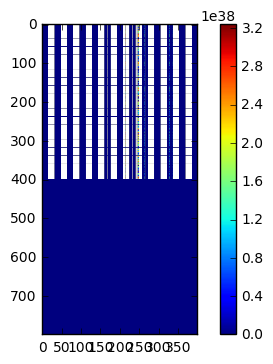

In [15]:
import pylab as plt
plt.imshow(np.abs(cc_gpu))
plt.colorbar()

In [45]:
# attempt to do matrix multiplication for real numbers
import pycuda.autoinit
from numpy import linalg as la
from pycuda import driver, compiler, gpuarray, tools
import numpy as np
from time import *

import skcuda.linalg as culinalg
import skcuda.misc as cumisc
culinalg.init()


# define the (square) matrix size
MATRIX_dimx = 6300; MATRIX_dimy = 51; MATRIX_dimt = 1000

# create two random square matrices
a_cpu = np.random.randn(MATRIX_dimy,MATRIX_dimt).astype(np.float32)
b_cpu = np.random.randn(MATRIX_dimt,MATRIX_dimx).astype(np.float32)

# compute reference on the CPU to verify GPU computation
t1 = time()
c_cpu = np.dot(a_cpu, b_cpu)
t2 = time()
t_cpu = t2-t1
# transfer host (CPU) memory to device (GPU) memory 
a_gpu = gpuarray.to_gpu(a_cpu) 
b_gpu = gpuarray.to_gpu(b_cpu)

# create empty gpu array for the result (C = A * B)
#c_gpu = gpuarray.empty((MATRIX_dimy,MATRIX_dimx), np.float32)
t1 = time()
c_gpu = culinalg.dot(a_gpu, b_gpu)
t2 = time()
t_gpu = t2-t1

# print the results
# print "-" * 80
# print "Matrix C (GPU):"
# print c_gpu.get()

# print "-" * 80
# print "Matrix C (CPU):"
# print c_cpu

# print "-" * 80
# print "Matrix C (GPU-CPU):"
# print c_gpu.get()-c_cpu

# print "-" * 80
# print "CPU-GPU difference:"
# print c_cpu - c_gpu.get()

print("CPU Time ", t_cpu)
print("GPU Time ", t_gpu)

print "L2 norm:", la.norm(c_cpu - c_gpu.get())
np.allclose(c_cpu**2, (c_gpu*c_gpu).get())

('CPU Time ', 0.013840913772583008)
('GPU Time ', 0.0008690357208251953)
L2 norm: 0.0106906


False

In [48]:
import pycuda.driver as drv
import pycuda.tools
import pycuda.autoinit
from pycuda.compiler import SourceModule
import pycuda.gpuarray as gpuarray
from pycuda.elementwise import ElementwiseKernel
import skcuda.linalg as culinalg
import skcuda.misc as cumisc
culinalg.init()

gauss_wfn = ElementwiseKernel(
    "float *dt, float *output, float res2",
    "output[i] = exp(-dt[i]*dt[i]/(2*res2))",
    "gauss",)
#post_process = ElementwiseKernel()
def _pass_gpu(dt, lres, data, wgts, shapeO):
    dt_gpu = gpuarray.to_gpu(dt.astype(np.float32))
    wgtfn_gpu = gpuarray.to_gpu(np.empty(dt.shape, dtype=np.complex64))
    gauss_wfn(dt_gpu, wgtfn_gpu, lres**2)
    print wgtfn_gpu.strides

    data_gpu = gpuarray.to_gpu(data.astype(np.complex64))
    wgts_gpu = gpuarray.to_gpu(wgts.astype(np.complex64))
    wgtgrid_gpu = culinalg.dot(wgts_gpu, wgtfn_gpu, transa='T')
    sumgrid_gpu = culinalg.dot(wgts_gpu*data_gpu, wgtfn_gpu, transa='T')
    
    return wgtgrid_gpu.get(), sumgrid_gpu.get()
    
def lst_grid_pycuda(lsts, data, wgts=None, lstbins=6300, wgtfunc=lambda dt,res: np.exp(-dt**2/(2*res**2))):
    lstgrid = np.linspace(0, 2*np.pi, lstbins)
    lstres = lstgrid[1]-lstgrid[0]
    if wgts is None: wgts = np.where(np.abs(data) == 0, 0, 1.)
    dt = lstgrid.reshape((1,-1))-lsts.reshape((-1,1))
    shapeO = (lstgrid.shape[0], data.shape[1])
    print wgts.T.shape, dt.shape
    wgtgrid, sumgrid = _pass_gpu(dt,lstres, data, wgts, shapeO)
    datagrid = np.where(wgtgrid > 1e-10, sumgrid/wgtgrid, 0)
    
    return datagrid, wgtgrid.real
lsts = np.linspace(0, 6.28, 1000, dtype=np.float32)
data = np.random.rand(1000, 51).astype(np.float32)
datagrid, wgtgrid = lst_grid_pycuda(lsts,data)


(51, 1000) (1000, 6300)
(50400, 8)


In [49]:
datagrid


array([[ 0.61537695 +0.00000000e+00j,  0.61537689 +0.00000000e+00j,
         0.61537701 +6.77707779e-10j, ...,  0.22169779 -4.80654538e-09j,
         0.22169779 +0.00000000e+00j,  0.22169781 +0.00000000e+00j],
       [ 0.63818723 +0.00000000e+00j,  0.63818723 +0.00000000e+00j,
         0.63818729 -6.77707779e-10j, ...,  0.19406676 +0.00000000e+00j,
         0.19406678 -6.07256911e-09j,  0.19406678 +0.00000000e+00j],
       [ 0.19179368 +0.00000000e+00j,  0.19179368 +0.00000000e+00j,
         0.19179368 +0.00000000e+00j, ...,  0.16683832 +0.00000000e+00j,
         0.16683830 -6.07256911e-09j,  0.16683832 +1.28365985e-09j],
       ..., 
       [ 0.07382081 +0.00000000e+00j,  0.07382081 +0.00000000e+00j,
         0.07382081 +3.38853889e-10j, ...,  0.42266464 +0.00000000e+00j,
         0.42266461 +0.00000000e+00j,  0.42266467 +0.00000000e+00j],
       [ 0.17698529 +0.00000000e+00j,  0.17698528 +1.70888437e-09j,
         0.17698531 +5.08280862e-10j, ...,  0.11673353 +0.00000000e+00j,
      